In [1]:
# Import needed libraries
import librosa
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

In [15]:
# Define a function to extract audio features from an audio file
def extract_audio_features(file_path, n_mfcc=13, n_chroma=12, n_contrast=6, max_len=200):

    # Load the audio file; sr=None preserves the native sampling rate
    audio, sample_rate = librosa.load(file_path, sr=None)
    
    # Extract MFCC (Mel-frequency cepstral coefficients) features
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    # Pad or truncate the MFCC feature matrix to ensure consistent dimensions
    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    
    # Extract chroma features (chroma energy normalized; represents pitch class energy)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate, n_chroma=n_chroma)
    # Pad or truncate the chroma feature matrix similarly for uniformity
    if chroma.shape[1] < max_len:
        chroma = np.pad(chroma, ((0, 0), (0, max_len - chroma.shape[1])), mode='constant')
    else:
        chroma = chroma[:, :max_len]
    
    # Extract spectral contrast (differences in amplitude across frequency bands)
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate, n_bands=n_contrast, fmin=200.0)
    # Ensure spectral contrast matrix matches the desired shape (padding/truncating as needed)
    if contrast.shape[1] < max_len:
        contrast = np.pad(contrast, ((0, 0), (0, max_len - contrast.shape[1])), mode='constant')
    else:
        contrast = contrast[:, :max_len]
    
    # Combine extracted features by stacking them vertically
    features = np.vstack((mfcc, chroma, contrast))
    
    return features


In [16]:
# Directory containing audio files to process
audio_speech = 'AudioWAV'

# Lists to store extracted features and labels for each audio file
features = []
labels = []
for file_name in os.listdir(audio_speech):
    if file_name.endswith('.wav'):  # Process only .wav files
        file_path = os.path.join(audio_speech, file_name)
        # Extract label based on filename (file name pattern ####_SentenceID_EmotionID_ToneID)
        # Emotion Labels are: Anger (ANG), Fear (FEA), Disgust (DIS), Happy (HAP), Neutral (NEU), Sad (SAD))
        label = file_name.split('_')[2]  # pulling the 3rd value from file name which is the emotion ID
        # Extract feature vector for the current file
        feature_vector = extract_audio_features(file_path)
        features.append(feature_vector)
        labels.append(label)

# Convert lists to DataFrame for easier data handling
feat_labs = pd.DataFrame({'Features': features, 'Label': labels})

# print features
print(feat_labs)

C:\Users\Donva\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


                                               Features Label
0     [[-589.8760375976562, -507.2122802734375, -465...   ANG
1     [[-494.1741027832031, -463.858154296875, -459....   DIS
2     [[-466.0972900390625, -458.12811279296875, -45...   FEA
3     [[-465.77593994140625, -436.8394470214844, -43...   HAP
4     [[-484.9637145996094, -454.3514099121094, -450...   NEU
...                                                 ...   ...
7437  [[-541.3533935546875, -512.3934326171875, -513...   DIS
7438  [[-500.56378173828125, -506.8985290527344, -51...   FEA
7439  [[-546.4652099609375, -513.5806274414062, -509...   HAP
7440  [[-549.4096069335938, -518.1360473632812, -514...   NEU
7441  [[-555.9723510742188, -515.941650390625, -507....   SAD

[7442 rows x 2 columns]


In [17]:
# Encode labels to numerical format for modeling
le = LabelEncoder()
feat_labs['Label'] = le.fit_transform(feat_labs['Label'])

# Convert features and labels to numpy arrays
X = np.array(feat_labs['Features'].tolist())  # Shape: (num_samples, num_features, max_len)
y = np.array(feat_labs['Label'].tolist())

# Convert arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create a dataset from the tensors and use DataLoader for batching and shuffling
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [19]:
# Define a neural network model class combining CNN and LSTM layers
class CNN_LSTM(nn.Module):
    def __init__(self, input_features, max_len, num_classes):
        super(CNN_LSTM, self).__init__()
        
        # Define the CNN layers for feature extraction
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=(1, 1))  # First convolution layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1)) # Second convolution layer
        self.pool = nn.MaxPool2d((2, 2))  # Max pooling layer to reduce spatial dimensions
        self.dropout = nn.Dropout(0.3)    # Dropout layer for regularization to prevent overfitting
        
        # Calculate the output dimensions after CNN layers to prepare input for LSTM
        cnn_out_height = input_features // 4  # Pooling reduces the height by a factor of 2 twice
        cnn_out_width = max_len // 4          # Pooling reduces the width by a factor of 2 twice
        lstm_input_size = 64 * cnn_out_height  # LSTM input size: channels (64) * reduced height
        
        # Define LSTM layers to capture temporal dependencies
        self.lstm = nn.LSTM(input_size=lstm_input_size, hidden_size=128, num_layers=2, batch_first=True)
        
        # Fully connected layer to map LSTM output to desired output classes
        self.fc = nn.Linear(128, num_classes)  # Linear layer with output size equal to the number of classes
        
    def forward(self, x):
        # Forward pass through CNN layers
        x = x.unsqueeze(1)  # Add a channel dimension (batch, 1, n_features, max_len) for CNN
        x = self.pool(torch.relu(self.conv1(x)))  # Apply first CNN layer, ReLU activation, and pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Apply second CNN layer, ReLU activation, and pooling
        
        # Reshape data for LSTM layer by flattening the height dimension
        batch_size, _, height, width = x.size()  # Get batch, channel, height, and width dimensions
        x = x.view(batch_size, width, -1)  # Reshape to (batch, sequence_length=width, features=channels*height)
        
        # Forward pass through LSTM layers
        x, _ = self.lstm(x)  # LSTM processes input, returns all time steps
        x = x[:, -1, :]      # Select the last time step's output for the final classification
        
        # Pass through the fully connected layer to obtain class scores
        x = self.fc(x)
        return x  # Return the output (logits) for each class


In [21]:
# Model parameters setup
input_features = X_tensor.size(1)  # Determine the number of input features
max_len = X_tensor.size(2)         # Sequence length, set to the fixed max_len used in feature extraction
num_classes = len(le.classes_)     # Determine the number of output classes (one for each label in the dataset)

# Initialize the CNN-LSTM model with defined parameters, loss function, and optimizer
model = CNN_LSTM(input_features=input_features, max_len=max_len, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with a learning rate of 0.001

# Training loop setup
num_epochs = 20  # Number of times the model will see the entire training set
for epoch in range(num_epochs):
    model.train()  # Set model to training mode (enables dropout and batch normalization)
    running_loss = 0.0  # Initialize running loss to keep track of loss during training

    # Loop through batches of data
    for X_batch, y_batch in train_loader:
        # Forward pass: compute model predictions for the current batch
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)  # Calculate loss between predictions and true labels
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero out gradients to prevent accumulation from previous steps
        loss.backward()        # Backpropagation: compute gradients of loss with respect to model parameters
        optimizer.step()        # Update model parameters based on computed gradients
        
        running_loss += loss.item()  # Accumulate the loss for reporting

    # Calculate and display average loss per epoch
    avg_loss = running_loss / len(train_loader)  # Average loss across all batches
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")  # Print progress

# Model evaluation on test data / training data (should we find new data for evaluation?)
model.eval()  # Set model to evaluation mode (disables dropout and batch normalization)
with torch.no_grad():  # Disable gradient calculations for efficiency during evaluation
    correct = 0  # Initialize counter for correct predictions
    total = 0    # Initialize counter for total samples

    # Loop through data in batches
    for X_batch, y_batch in train_loader:  
        outputs = model(X_batch)  # Forward pass to get model predictions
        _, predicted = torch.max(outputs, 1)  # Get predicted class for each sample
        total += y_batch.size(0)  # Count total samples in the batch
        correct += (predicted == y_batch).sum().item()  # Count correct predictions

    # Calculate and display accuracy
    # Side note: we get different accuarcy scores each time we run entire model, should we consider seeding?
    accuracy = 100 * correct / total  # Calculate accuracy as a percentage
    print(f"Test Accuracy: {accuracy:.2f}%")  # Print the model's accuracy


Epoch [1/20], Loss: 1.5124
Epoch [2/20], Loss: 1.4302
Epoch [3/20], Loss: 1.4145
Epoch [4/20], Loss: 1.3691
Epoch [5/20], Loss: 1.3397
Epoch [6/20], Loss: 1.3175
Epoch [7/20], Loss: 1.2784
Epoch [8/20], Loss: 1.2189
Epoch [9/20], Loss: 1.1818
Epoch [10/20], Loss: 1.1226
Epoch [11/20], Loss: 1.0693
Epoch [12/20], Loss: 0.9871
Epoch [13/20], Loss: 0.9100
Epoch [14/20], Loss: 0.8144
Epoch [15/20], Loss: 0.7311
Epoch [16/20], Loss: 0.6503
Epoch [17/20], Loss: 0.5508
Epoch [18/20], Loss: 0.5068
Epoch [19/20], Loss: 0.4346
Epoch [20/20], Loss: 0.3668
Test Accuracy: 90.66%


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Placeholder lists to store true and predicted labels
y_true = []
y_pred = []

# Switch model to evaluation mode
model.eval()
with torch.no_grad():
    for X_batch, y_batch in train_loader: 
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        
        # Append true and predicted labels
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [23]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=le.classes_)
print(report)


              precision    recall  f1-score   support

         ANG       0.93      0.94      0.93      1271
         DIS       0.91      0.91      0.91      1271
         FEA       0.85      0.94      0.89      1271
         HAP       0.92      0.83      0.87      1271
         NEU       0.92      0.93      0.92      1087
         SAD       0.93      0.90      0.91      1271

    accuracy                           0.91      7442
   macro avg       0.91      0.91      0.91      7442
weighted avg       0.91      0.91      0.91      7442



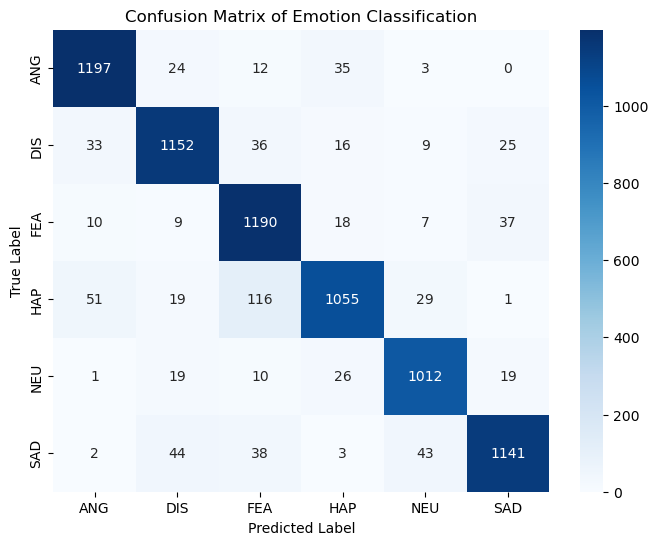

In [25]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Emotion Classification")
plt.show()
